## Repo Analysis

In [1]:
from utils.git_utils import clone_repo
from pathlib import Path
from analyzers.code_analyzer import CodeAnalyzer, NodeKind, is_kind
url = 'https://github.com/adiprerepa/cs598APE-hw1'
branch = 'master'
repo = clone_repo(url, branch=branch)
working_dir = repo.working_dir
print(f"Working directory: {working_dir}")
PROJECT_DIR = Path(working_dir).resolve()

analyzer = CodeAnalyzer(PROJECT_DIR)
graph = analyzer.graph

Working directory: /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1
✅ libclang loaded from: /usr/lib/llvm-18/lib/libclang.so
✅ Uber file generated at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/__uber.cpp
Found 3882 nodes
Found 1821 edges
Merging node TimeAndShape into TimeAndShape::TimeAndShape


⚠️ Graph is not a DAG. Using SCC condensation for level estimation.
⚠️ Found cycles: [['Autonoma::Autonoma', 'Shape::Shape']]


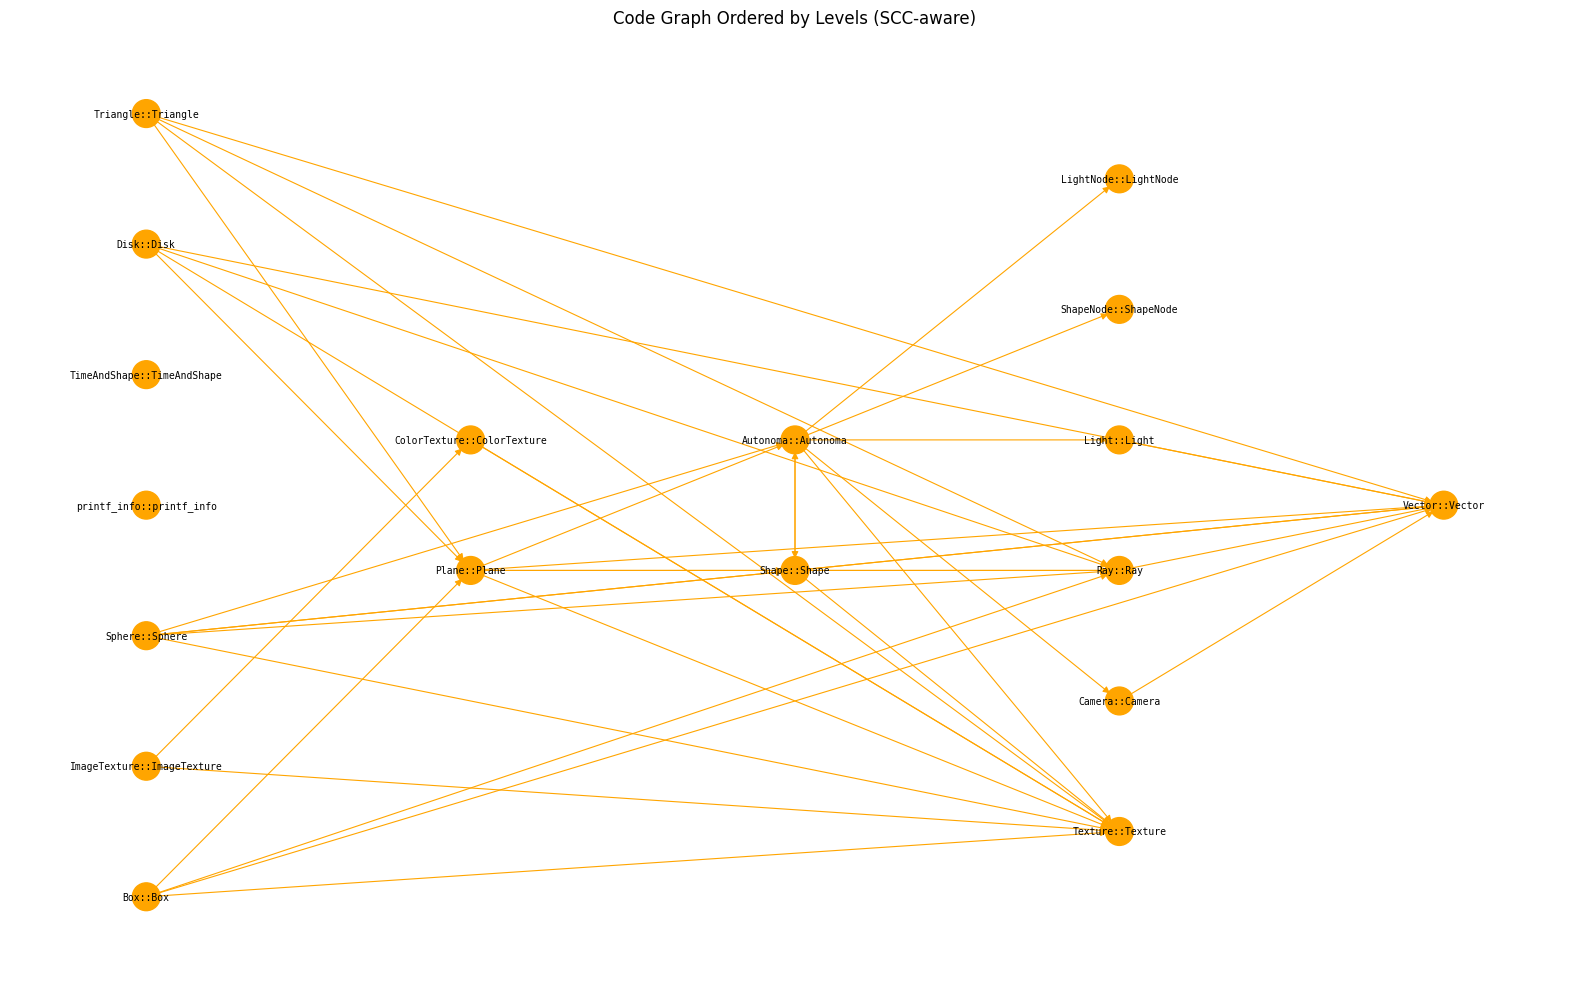

In [20]:
analyzer.plot(horizontal=True, node_filter=lambda node, attrs: is_kind(attrs["kind"], NodeKind.TYPE) and is_kind(attrs["kind"], NodeKind.IN_CODEBASE))

In [21]:
from utils.cursor_utils import loc_info, CTOR_KINDS
node = 'Plane::Plane'
code = graph.nodes[node]['code']
print(f"Code for {node}:\n{code}")
# print the node's successors
successors = list(graph.successors(node))
print(f"Successors of {node}: {successors}")
# print the node's predecessors
predecessors = list(graph.predecessors(node))
print(f"Predecessors of {node}: {predecessors}")
# print the url of the file
file = graph.nodes[node]['file']
line = graph.nodes[node]['line']
print(f"File: {file}:{line}")
# print if the node is library or user defined
node_kind = graph.nodes[node]['kind']
# Access all the member variables of NodeKind
kinds = list(NodeKind)
for kind in kinds:
    if is_kind(node_kind, kind):
        print(f"{node} is of kind {NodeKind(kind).name}")

Code for Plane::Plane:
class Plane : public Shape{
public:
  Vector vect, right, up;
  double d;
  Plane(const Vector &c, Texture* t, double ya, double pi, double ro, double tx, double ty);
  double getIntersection(Ray ray);
  bool getLightIntersection(Ray ray, double* toFill);
  void move();
  void getColor(unsigned char* toFill, double* am, double* op, double* ref, Autonoma* r, Ray ray, unsigned int depth);
  Vector getNormal(Vector point);
  unsigned char reversible();
  void setAngles(double yaw, double pitch, double roll);
  void setYaw(double d);
  void setPitch(double d);
  void setRoll(double d);
};
Successors of Plane::Plane: ['Shape::Shape', 'Vector::Vector', 'Texture::Texture', 'Ray::Ray', 'Autonoma::Autonoma']
Predecessors of Plane::Plane: ['Plane::Plane(const Vector &, Texture *, double, double, double, double, double)', 'Plane::getIntersection', 'Plane::getLightIntersection', 'Plane::move', 'Plane::getColor', 'Plane::getNormal', 'Plane::reversible', 'Plane::setAngles', 'P

In [11]:
import subprocess
import json
import networkx as nx
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_cli_and_get_successors(codebase_dir, function_name):
    try:
        result = subprocess.run(
            ["python3", "analyzers/dependency_extractor.py", codebase_dir, function_name],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )
        output = result.stdout.strip()

        successors = set()
        inside_func = False

        for line in output.splitlines():
            stripped = line.strip()
            if stripped.startswith("Function:"):
                inside_func = True
            elif stripped.startswith("Dependencies:"):
                continue
            elif "Function calls:" in stripped:
                continue
            elif stripped.startswith("- Name:"):
                name = stripped.split(":", 1)[-1].strip()
                if name:
                    successors.add(name)

        return function_name, successors

    except Exception as e:
        print(f"⚠️ Error running CLI for {function_name}: {e}")
        return function_name, set()

def compare_graph_to_cli(graph: nx.DiGraph, codebase_dir: str, max_workers: int = 8):
    print("\n🔍 Verifying successors (parallel)...")
    non_superset = []

    subgraph = analyzer.induce_subgraph(
        node_filter=lambda node, attrs: attrs["kind"] & NodeKind.FUNCTION and attrs["kind"] & NodeKind.IN_CODEBASE
    )

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_func = {
            executor.submit(run_cli_and_get_successors, codebase_dir, func): func
            for func in subgraph.nodes
        }

        for future in as_completed(future_to_func):
            func = future_to_func[future]
            cli_successors = set()
            try:
                func_name, cli_successors = future.result()
            except Exception as e:
                print(f"⚠️ Failed to get result for {func}: {e}")
                continue
            cli_successors = cli_successors
            graph_successors = graph.successors(func)
            # constraint the successors to only those which are functions or types
            graph_successors = {n for n in graph_successors if graph.nodes[n].get("kind") in {"function", "type"}}
            # if graph succesors is not a superset of cli successors
            if not cli_successors.issubset(graph_successors):
                non_superset.append((func, graph_successors, cli_successors))
                print(f"\n❌ Mismatch for: {func}")
                print(f"  ➤ Graph: {sorted(graph_successors)}")
                print(f"  ➤ CLI  : {sorted(cli_successors)}")
            else:
                print(f"\n✅ Match for: {func}")

    if not non_superset:
        print("\n✅ The graph is a superset of the CLI")
    else:
        print(f"\n❌ Found {len(non_superset)} non superset nodes.")

    return non_superset


print(str(PROJECT_DIR))

mismatches = compare_graph_to_cli(graph, str(PROJECT_DIR), max_workers=128)

/home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1

🔍 Verifying successors (parallel)...

❌ Mismatch for: cosfn
  ➤ Graph: []
  ➤ CLI  : ['cos']

✅ Match for: identity

❌ Mismatch for: Plane::getColor
  ➤ Graph: []
  ➤ CLI  : ['Texture::getColor', 'Vector::Vector', 'Vector::operator-', 'fix', 'solveScalers']

❌ Mismatch for: Plane::setAngles
  ➤ Graph: []
  ➤ CLI  : ['Vector::Vector', 'Vector::dot', 'cos', 'sin']

❌ Mismatch for: outputPPM
  ➤ Graph: []
  ➤ CLI  : ['fclose', 'fopen', 'fprintf', 'fwrite', 'outputPPM']

❌ Mismatch for: get
  ➤ Graph: []
  ➤ CLI  : ['std::operator|=']

❌ Mismatch for: parseTexture
  ➤ Graph: []
  ➤ CLI  : ['ColorTexture::ColorTexture', 'ImageTexture::ImageTexture', 'ImageTexture::maskImageAlpha', 'ImageTexture::setColor', 'exit', 'getline', 'printf', 'sscanf', 'streq']

❌ Mismatch for: refresh
  ➤ Graph: []
  ➤ CLI  : ['Ray::Ray', 'Vector::Vector', 'Vector::operator+', 'calcColor', 'operator*']

✅ Match for: Shape::getNormal

❌ Mismatch for: fpeek
  ➤ Gra

In [ ]:
import re

print("\n--- Nodes with degree 0 --- that may not deserve it")

whitelist = {'min', 'max', 'empty', 'size', 'full', 'pop', 'operator()', 'push'}

for n in graph.nodes:
    token = n.split("::")[-1]
    if token in whitelist: continue
    if graph.degree(n) == 0:
        # get the bare function name (no namespaces)
        
        # build a regex that:
        #  - won’t match inside larger identifiers
        #  - won’t match parts of a namespace like “My::foo” inside “My::foobar”
        # (?<![\w:])  = not preceded by a word‑char or colon
        # (?![\w])    = not followed by a word‑char
        pat = re.compile(r"(?<![\w:])" + re.escape(token) + r"(?![\w])")
        
        for m in graph.nodes:
            if m == n:
                continue

            code = graph.nodes[m]["code"]
            for match in pat.finditer(code):
                print("=========")
                print(f"Node {n} is referenced in {m}:")
                # location info
                loc_n = graph.nodes[n]
                loc_m = graph.nodes[m]
                print(f"  {n} defined at {loc_n['file']}:{loc_n['line']}")
                print(f"  {m} defined at {loc_m['file']}:{loc_m['line']}")
                
                # show the snippet around the match
                start, end = match.span()
                snippet = code[max(0, start-30):min(len(code), end+30)]
                # highlight the match with brackets
                highlighted = snippet.replace(
                    snippet[start - max(0, start-30): end - max(0, start-30)],
                    f"[{token}]"
                )
                print("  code context:", highlighted)
                
                # optionally print full code+AST if you still need it
                print(graph.nodes[m]['code'])
                print("==========\n")
                # once we’ve found one match, we can stop scanning this m
                break



--- Nodes with degree 0 --- that may not deserve it
Node printf_info::printf_info is referenced in print_vector:
  printf_info::printf_info defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:82
  print_vector defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:82
  code context: or(FILE *stream, const struct [printf_info] *info, const void 
*const *ar
int print_vector(FILE *stream, const struct printf_info *info, const void 
*const *args);

Node printf_info::printf_info is referenced in print_vector_arginfo:
  printf_info::printf_info defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:82
  print_vector_arginfo defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:85
  code context: _vector_arginfo (const struct [printf_info] *info, size_t n, int 
*argtyp
int print_vector_arginfo (const struct printf_info *info, size_t n, int 
*argtypes);

Node Texture::clone is referenced in Texture::Texture:
 

## Obfuscation

In [ ]:
import hashlib
import os
import re
from pathlib import Path
from typing import Dict, Set, List

from clang import cindex
from clang.cindex import CursorKind

from utils.string_utils import remove_comments, word_list


class Obfuscator:
    _word_pat_cache: Dict[frozenset, re.Pattern] = {}

    _CURSOR_KINDS_BY_TIER: Dict[int, Set[CursorKind]] = {
        2: {  # Variable names (user-defined)
            CursorKind.VAR_DECL,
            CursorKind.PARM_DECL,
            CursorKind.FIELD_DECL,
            CursorKind.ENUM_CONSTANT_DECL,
            CursorKind.MACRO_INSTANTIATION,
            CursorKind.MACRO_DEFINITION,
            CursorKind.MEMBER_REF_EXPR,
            CursorKind.DECL_REF_EXPR,
        },
        3: {  # Add user-defined functions & class names
            CursorKind.FUNCTION_DECL,
            CursorKind.CXX_METHOD,
            CursorKind.FUNCTION_TEMPLATE,
            CursorKind.STRUCT_DECL,
            CursorKind.CLASS_DECL,
            CursorKind.CLASS_TEMPLATE,
            CursorKind.TYPEDEF_DECL,
            CursorKind.TYPE_ALIAS_DECL,
            CursorKind.TYPE_ALIAS_TEMPLATE_DECL,
            CursorKind.ENUM_DECL,
            CursorKind.TEMPLATE_TYPE_PARAMETER,
            CursorKind.TEMPLATE_NON_TYPE_PARAMETER,
            CursorKind.TEMPLATE_TEMPLATE_PARAMETER,
            CursorKind.NAMESPACE,
            CursorKind.TEMPLATE_REF,
            CursorKind.TYPE_REF,
        },
        4: set()  # Same as tier 3, but allows library symbols
    }

    def __init__(self, tier: int, nodes: List[dict], project_root: Path, prefix: str = "o_"):
        if not (0 <= tier <= 4):
            raise ValueError("tier must be between 0 and 4")
        self.tier = tier
        self.prefix = prefix
        self.project_root = project_root.resolve()

        self._kinds = self._resolve_kinds()
        self._tokens = self._collect_tokens(nodes)
        self._obf_map = self._create_obf_map(self._tokens)
        self._pattern = self._compiled_word_pattern(self._tokens)

    def obfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        if self.strip_comments:
            code = remove_comments(code)

        def repl(match: re.Match[str]) -> str:
            return self._obf_map[match.group(0)]

        return self._pattern.sub(repl, code)

    def deobfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        reverse_map = {v: k for k, v in self._obf_map.items()}
        pattern = self._compiled_word_pattern(set(reverse_map))

        def repl(match: re.Match[str]) -> str:
            return reverse_map[match.group(0)]

        return pattern.sub(repl, code)

    @property
    def obfuscation_map(self) -> Dict[str, str]:
        return self._obf_map

    @property
    def strip_comments(self) -> bool:
        return self.tier >= 1

    def _resolve_kinds(self) -> Set[cindex.CursorKind]:
        if self.tier < 2:
            return set()
        kinds = set()
        for t in range(2, self.tier + 1):
            kinds.update(self._CURSOR_KINDS_BY_TIER.get(t, set()))
        return kinds

    def _collect_tokens(self, nodes: List[dict]) -> Set[str]:
        tokens = set()

        def _should_obfuscate(cur: cindex.Cursor) -> bool:
            if cur is None or cur.kind == CursorKind.TRANSLATION_UNIT:
                return False
            if cur.kind not in self._kinds:
                return False
            if self.tier >= 4:
                return True
            return self._is_user_defined(cur)

        def _recurse(cur: cindex.Cursor):
            if _should_obfuscate(cur) and cur.spelling:
                tokens.add(cur.spelling)
            for child in cur.get_children():
                _recurse(child)

        for node in nodes:
            cursor = node.get("cursor")
            if cursor:
                _recurse(cursor)

        return tokens

    def _create_obf_map(self, tokens: Set[str]) -> Dict[str, str]:
        mapping = {}
        used_words = set()
        for token in tokens:
            word = random.choice(word_list)[:5]
            while word in used_words or word in tokens:
                word = random.choice(word_list)[:5]
            mapping[token] = f"{self.prefix}{word}"
        return mapping

    def _compiled_word_pattern(self, words: Set[str]) -> re.Pattern:
        key = frozenset(words)
        if key in self._word_pat_cache:
            return self._word_pat_cache[key]
        altern = "|".join(map(re.escape, sorted(words, key=len, reverse=True)))
        pat = re.compile(rf"(?<!\w)(?:{altern})(?!\w)")
        self._word_pat_cache[key] = pat
        return pat

    def _is_user_defined(self, cursor: cindex.Cursor) -> bool:
        definition = cursor.get_definition()
        loc_file = (
            definition.location.file.name
            if definition and definition.location.file
            else cursor.location.file.name
            if cursor.location.file
            else None
        )
        if loc_file is None:
            return self.tier >= 4

        file_path = Path(loc_file).resolve()
        try:
            in_project = file_path.is_relative_to(self.project_root)
        except AttributeError:
            in_project = str(file_path).startswith(str(self.project_root))

        is_writeable = os.access(file_path, os.W_OK)
        return in_project or is_writeable or self.tier >= 4


import random
import textwrap

random_node = random.choice(list(graph.nodes))
successors = list(graph.successors(random_node))
nodes = [graph.nodes[n] for n in successors]
nodes.append(graph.nodes[random_node])

obfuscator = Obfuscator(tier=3, nodes=nodes, project_root=PROJECT_DIR)

code = "\n".join(n["code"] for n in nodes)

obfuscated_code = obfuscator.obfuscate(code)
deobfuscated_code = obfuscator.deobfuscate(obfuscated_code)

print("\nOriginal code:")
print(textwrap.indent(code, "  "))

print("\nObfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))

print("\nObfuscation map:")
for orig, obf in obfuscator.obfuscation_map.items():
    print(f"  {orig} -> {obf}")

if remove_comments(deobfuscated_code) == remove_comments(code):
    print("\n✅ Deobfuscation successful!")
else:
    print("\n❌ Deobfuscation failed.")
    # print the deobfuscated code
    print(textwrap.indent(deobfuscated_code, "  "))
    


Original code:
  class Sphere : public Shape{
  public:
    double radius;
    Sphere(const Vector &c, Texture* t, double ya, double pi, double ro, double radius);
    double getIntersection(Ray ray);
    void move();
    bool getLightIntersection(Ray ray, double* fill);
    void getColor(unsigned char* toFill, double* am, double* op, double* ref, Autonoma* r, Ray ray, unsigned int depth);
    Vector getNormal(Vector point);
    unsigned char reversible();
    void setAngles(double a, double b, double c);
    void setYaw(double a);
    void setPitch(double b);
    void setRoll(double c);
  };
  double yaw, pitch,
  double yaw, pitch, roll, xsin, xcos, ysin, ycos,
  double yaw, pitch, roll, xsin, xcos, ysin,
  void Sphere::setPitch(double b){
     pitch = b;
     ycos = cos(pitch);
     ysin = sin(pitch);
  }


Obfuscated code:
  o_outlo : public Shape{
  public:
    double o_villo;
    o_serme(const Vector &o_Mithr, Texture* o_versi, double o_Fusus, double o_simbi, double o_aumer, dou

## Optimization

In [ ]:
from typing import Optional, List, Dict
import openai
import anthropic
from collections import deque
from utils.string_utils import extract_markdown_blocks, markdown_to_dict

class OptimizerAgent:
    def __init__(self, model: str, provider: str = "openai", api_key: Optional[str] = None):
        self.model = model
        self.provider = provider
        self.api_key = api_key

        # Simulate backend client (replace with real SDKs)
        if provider == "openai":
            self.client = openai.OpenAI(api_key=api_key)
        elif provider == "anthropic":
            self.client = anthropic.Anthropic(api_key=api_key)
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def prompt(self,
               input_prompt: str,
               context_window: Optional[List[str]] = None,
               system_message: Optional[str] = "You are an expert C++ performance optimization engineer.",
               temperature: float = 0.7,
               max_tokens: int = 4096) -> str:
        messages = []
        if system_message:
            messages.append({"role": "system", "content": system_message})
        if context_window:
            messages.extend({"role": "user", "content": m} for m in context_window)
        messages.append({"role": "user", "content": input_prompt})

        if self.provider == "openai":
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.choices[0].message.content

        elif self.provider == "anthropic":
            messages = []
            if system_message:
                messages.append({"role": "system", "content": system_message})
            if context_window:
                messages.extend({"role": "user", "content": m} for m in context_window)
            messages.append({"role": "user", "content": input_prompt})

            response = self.client.messages.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.content[0].text


    def optimize_node(self,
                    node: str,
                    obfuscation_tier: int = 0,
                    context_window: Optional[List[str]] = None,
                    system_message: Optional[str] = None,
                    context_depth: int = 0,
                    response_format: Optional[str] = None) -> None:
        """
        Optimize a code node from a graph.
        """
        labels = graph.nodes[node]
        code = labels.get("code", "").strip()
        if not code:
            raise ValueError("Node has no code")

        file_path = labels.get("file", "<unknown file>")

        
        # get all nodes within 3 hops of the current node from the graph 
        context_nodes = list(nx.single_source_shortest_path_length(graph, node, cutoff=context_depth).keys())
        obfuscator = Obfuscator(
            tier=obfuscation_tier,
            nodes=[graph.nodes[n] for n in context_nodes],
            project_root=PROJECT_DIR
        )
        code = obfuscator.obfuscate(code) if obfuscator else code
        additional_context = []
        for n in context_nodes:
            if n == node:
                continue
            context_node = graph.nodes[n]
            context_code = context_node.get("code", "").strip()
            if context_code:
                context_code = obfuscator.obfuscate(context_code) if obfuscator else context_code
                additional_context.append(f"File: {context_node['file']}\n```cpp\n{context_code}\n```")

        if context_window is None:
            context_window = []
        context_window.extend(additional_context)

        prompt = (
            f"Optimize the following function {node} for performance. "
            "Only modify the internals, and keep the function name and signature the same.\n"
            f"\n```cpp\n{code}\n```"
            # If there is a response format specified, include it in the prompt
            + (f"\n\nResponse format:\n{response_format}" if response_format else "")
        )

        response = self.prompt(input_prompt=prompt, context_window=context_window, system_message=system_message)

        if obfuscator:
            response = obfuscator.deobfuscate(response)
        return response
        

# Example usage
optimizer = OptimizerAgent(model="claude-3-opus-20240229", provider="anthropic", api_key=os.getenv("ANTHROPIC_API_KEY"))
print(optimizer.optimize_node(node=random_node, context_depth=1))


To optimize the `Vector::operator-` function for performance, you can avoid creating a temporary `Vector` object and instead directly return the result of the subtraction. Here's the optimized version:

```cpp
Vector Vector::operator - (const Vector rhs) {
   return {x - rhs.x, y - rhs.y, z - rhs.z};
}
```

In the original code, a temporary `Vector` object is created using the constructor `Vector(x-rhs.x, y-rhs.y, z-rhs.z)`, which involves additional memory allocation and initialization.

By using the initializer list syntax `{x - rhs.x, y - rhs.y, z - rhs.z}`, you can directly initialize and return a `Vector` object without the need for a temporary object. This can provide a slight performance improvement, especially if the `Vector` subtraction operation is frequently used in performance-critical code.

The optimized version achieves the same functionality as the original code but with potentially better performance by avoiding the unnecessary temporary object creation.
